In [212]:
from scipy.integrate import odeint
import numpy as np
import math
from grid import Hyperrect
import itertools
import pdb
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import deque 
SAFE = 1
UNSAFE = -1
UNKNOWN = 0

In [213]:
def bloatToTube(k, gamma, init_delta_array, trace, dimensions):
    center_trace = trace
    reach_tube = []

    for i in range(trace_len-1):
        time_interval = center_trace[i+1][0] - center_trace[0][0]
        lower_rec = [center_trace[i][0]]
        upper_rec = [center_trace[i+1][0]]

        for dim in range(1,dimensions):
            delta = k[dim-1] * exp(gamma[dim-1]*time_interval) * init_delta_array[dim-1]
            upper_rec.append(max(center_trace[i+1][dim],center_trace[i][dim])+delta)
            lower_rec.append(min(center_trace[i+1][dim],center_trace[i][dim])-delta)
        reach_tube.append(lower_rec)
        reach_tube.append(upper_rec)
    return reach_tube

In [214]:
def position(p, t, cd1, vc, m, k1, k2, k3, x_o, y_o, x_n, y_n):
    # get initial conditions
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i

    # constants
    g = 32.2            # ft/sec

    # compute dvdt
    D = cd1 * v**2      # drag
    T = k1*m*(vc - v)   # thrust
    dvdt = (T-D)/m      # v'

    # compute Fct, current crosstrack error
    p1 = np.array([x-x_o, y-y_o])
    p2 = np.array([x-x_n, y-y_n])
    lam = (p2-p1)/np.linalg.norm(p2-p1)
    Fct = np.linalg.norm(np.cross(lam, p1))

    # compute psi
    sh_old = math.acos((y_n - y) / (math.sqrt((x_n - x)*(x_n - x) + (y_n - y)*(y_n - y))))
    if y_n > y:
        sh = math.atan((x_n-x)/(y_n-y))
    else:
        sh = (np.pi/2) + math.atan((y-y_n)/(x_n-x))
        
    dot = x*x_n + y*y_n      # dot product between [x1, y1] and [x2, y2]
    det = x*y_n - y*x_n      # determinant
    sh = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    #if (abs(sh_old - sh) > 0.001):
    #    pdb.set_trace()
    h = (k2*v/g) * (sh - s) #+ k3*Fct
    #h = (k2*v/g) * (sh - s)
    dsdt = (g/v) * np.sin(h)

    dxdt = v * np.sin(s)
    dydt = v * np.cos(s)

    return [dvdt, dsdt, dxdt, dydt]

In [215]:
def PointCoordinateChange(sc, p, x_n, y_n):
    v1 = p[0]            # velocity
    s1 = p[1]            # psi
    x1 = p[2]            # x_i
    y1 = p[3]            # y_i
    y2 = (y1 - y_n)*math.cos(sc) +  (x1 - x_n)*math.sin(sc)
    x2 = -(y1 - y_n)*math.sin(sc) + (x1 - x_n)*math.cos(sc)
    s2 = s1 - sc
    v2 = v1
    return [v2, s2, x2, y2]

In [216]:
def List1dCoordinateChange(sc, l, x_n, y_n):
    L = []
    for i in range(len(l)):
        L.append(PointCoordinateChange(sc,l[i],x_n,y_n))
    return L

In [217]:
def List2dCoordinateChange(sc, l, x_n, y_n):
    L = []
    for i in range(len(l)):
        L.append(List1dCoordinateChange(sc, l[i], x_n, y_n))
    return L

In [218]:
PointCoordinateChange(math.pi/6, [1,0,math.sqrt(3),1], 0, 0)

[1, -0.5235987755982988, 1.0, 1.7320508075688772]

In [219]:
def PositionPointCoordinateChange(sc, x1,y1, x_n, y_n):
    x2 = (x1 - x_n)*math.cos(sc) +  (y1 - y_n)*math.sin(sc)
    y2 = -(x1 - x_n)*math.sin(sc) + (y1 - y_n)*math.cos(sc)
    return [x2, y2]

In [220]:
def inversePointCoordinateChange(sc, p, x_n, y_n):
    v1 = p[0]            # velocity
    s1 = p[1]            # psi
    x1 = p[2]            # x_i
    y1 = p[3]            # y_i
    y2 = y1*math.cos(sc) - x1*math.sin(sc) + y_n
    x2 = y1*math.sin(sc) + x1*math.cos(sc) + x_n
    s2 = s1 + sc
    v2 = v1
    return [v2, s2, x2, y2]

In [221]:
inversePointCoordinateChange(math.pi/6,[1,0,2,0], 0, 0)

[1, 0.5235987755982988, 1.7320508075688774, -0.9999999999999999]

In [222]:
def standardized_position(p, t, cd1, vc, m, k1, k2, k3):
    # get initial conditions
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i
    
    # constants
    g = 32.2            # ft/sec
    
    # compute dvdt
    D = cd1 * v**2      # drag
    T = k1*m*(vc - v)   # thrust
    dvdt = (T-D)/m      # v'
    
    # compute Fct, current crosstrack error
    #p1 = np.array([x-p[2], y-p[3]])
    #p2 = np.array([x-x_n, y-y_n])
    #lam = (p2-p1)/np.linalg.norm(p2-p1)
    
    ##TODO: there is dependence on wp_o in Fct and on wp_n by psi (s here), so we will skip Fct for now
    # but need to handle it later
    #Fct = np.linalg.norm(y)
    
    #compute psi
    sh_old = math.acos((- y) / (math.sqrt(x*x + y*y)))
    if 0 > y:
        sh = math.atan((x)/(y))
    else:
        sh = (np.pi/2) + math.atan((y)/(-x))
        
    dot = y      # dot product between [x1, y1] and [x2, y2]
    det = x      # determinant
    sh = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    #if (abs(sh_old - sh) > 0.001):
    #    pdb.set_trace()
    #h = -1*(k2*v/g) * s #+ k3 * Fct
    h = (k2*v/g) * (sh - s)
    dsdt = (g/v) * np.sin(h)
    dxdt = v * np.sin(s)
    dydt = v * np.cos(s)
    #print "derivatives: ", dxdt, dydt

    return [dvdt, dsdt, dxdt, dydt]

In [223]:
center = [0.5, 0.9, -0.5, -0.5]
time_step = 0.1
time_bound = 10
number_points = int(np.ceil(time_bound/time_step))
t = [i*time_step for i in range(0,number_points)]
if t[-1] != time_step:
    t.append(time_bound)
newt = []
for step in t:
    newt.append(float(format(step, '.2f')))
t = newt
while t[-1] == t[-2]:
    t.pop()

red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
red_args_orig = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6, center[2], center[3],3.5,0.5)
sc = 0

wp_o = [center[2],center[3]]
wp_n = [3.5,0.5]
sc = math.acos((wp_n[1] - wp_o[1]) / (math.sqrt((wp_n[0] - wp_o[0])*(wp_n[0] - wp_o[0]) + (wp_n[1] - wp_o[1])*(wp_n[1] - wp_o[1]))))
print "sc new: ", sc
if 0.5 > center[3]:
    sc = math.atan((3.5-(center[2]))/(0.5-(center[3])))
else:
    sc = (np.pi/2) + math.atan((center[3]-0.5)/(3.5-(center[2])))
print "sc old:",sc
center_trans = PointCoordinateChange(sc, center, 3.5, 0.5)
sol = odeint(standardized_position,center_trans,t,args=red_args, hmax = time_step)
sol_orig = odeint(position,center,t,args=red_args_orig, hmax = time_step)
sol = odeint(standardized_position,center_trans,t,args=red_args, hmax = time_step)
for i in range(len(sol)):
    print inversePointCoordinateChange(sc,sol[i],3.5, 0.5), sol_orig[i]
    print "difference in angle : ", sol[i][1] - sol_orig[i][1]

sc new:  1.32581766367
sc old: 1.32581766367
[0.5, 0.90000000000000002, -0.5, -0.5] [ 0.5  0.9 -0.5 -0.5]
difference in angle :  -1.32581766367
[0.51388140530237558, 0.74202871622259092, -0.46296681332842349, -0.46543337843575505] [ 0.51388139  0.99274058 -0.45885076 -0.4703934 ]
difference in angle :  -1.57652952929
[0.52582678752561873, 0.59366275036515115, -0.43083620700764902, -0.42460806561745545] [ 0.52582678  1.07907587 -0.41410864 -0.44392644]
difference in angle :  -1.81123078346
[0.5361061122559837, 0.45444921699393259, -0.40432640357706173, -0.37863742934712885] [ 0.53610611  1.15874222 -0.36632647 -0.42077492]
difference in angle :  -2.03011066332
[0.54495171273693865, 0.32394896737659873, -0.38387082207519008, -0.32863406593983235] [ 0.54495171  1.23135647 -0.31603141 -0.40097507]
difference in angle :  -2.23322516687
[0.55256353286309789, 0.20173374711515057, -0.36966223282984512, -0.27565516243527277] [ 0.55256353  1.29640067 -0.26370807 -0.38443421]
difference in angle 

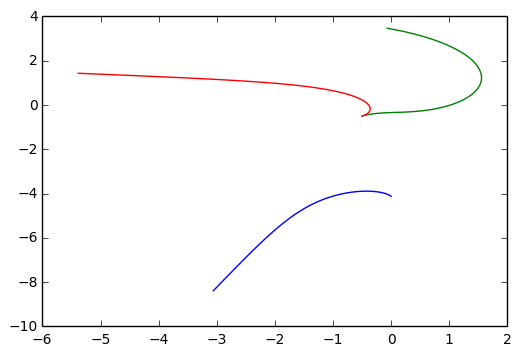

In [224]:
%matplotlib inline
plt.plot(np.array(sol[:])[:,2],np.array(sol[:])[:,3],'b')
plt.plot(np.array(sol_orig[:])[:,2],np.array(sol_orig[:])[:,3],'g')
inverted_sol =[]
for i in range(len(sol)):
    inverted_sol.append(inversePointCoordinateChange(sc,sol[i],3.5,0.5))
#print inverted_sol
#plt.axis('scaled')
plt.plot(np.array(inverted_sol[:])[:,2],np.array(inverted_sol[:])[:,3],'r')

In [187]:
def TC_Simulate(Mode,initialCondition,time_bound):
    time_step = 0.1;
    time_bound = float(time_bound)

    number_points = int(np.ceil(time_bound/time_step))
    t = [i*time_step for i in range(0,number_points)]
    if t[-1] != time_step:
        t.append(time_bound)
    newt = []
    for step in t:
        newt.append(float(format(step, '.2f')))
    t = newt
    while t[-1] == t[-2]:
        t.pop()
    red_args = 0
    if Mode=="first;first":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 2600, -750, 5000, 2000)
    elif Mode=="second;second":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 5000, 2000, 5750, 3500)
    elif Mode=="third;third":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 5750, 3500, 7500, 4250)
    elif Mode=="fourth;fourth":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 7500, 4250, 9250, 3750)
    print "InitialCondition:",initialCondition
    sol = odeint(position,initialCondition,t,args=red_args, hmax = time_step)
    # Construct the final output
    trace = []
    for j in range(len(t)):
        #print t[j], current_psi
        tmp = []
        tmp.append(t[j])
        tmp.append(float(sol[j,0]))
        tmp.append(float(sol[j,1]))
        tmp.append(float(sol[j,2]))
        tmp.append(float(sol[j,3]))
        trace.append(tmp)
    return np.array(trace)

In [188]:
def time_List(time_step, time_bound):
    number_points = int(np.ceil(time_bound/time_step))
    t = [i*time_step for i in range(0,number_points)]
    if t[-1] != time_step:
        t.append(time_bound)
    newt = []
    for step in t:
        newt.append(float(format(step, '.2f')))
    t = newt
    while t[-1] == t[-2]:
        t.pop()
    return t

In [189]:
def TC_Simulate_Single(d, initState, waypointslist, time_step, time_bound, traces, computed_sims, res):
    cur_goal = 0
    time_left = time_bound
    
    c_num_computed_sims = 0
    c_num_trans_sims = 0
    
    t = time_List(time_step, time_bound)

    wp_o = [initState[2],initState[3]]
    wp_n = waypointslist[cur_goal]
    trace = []
    trace_orig = []
    trace_unified = []
    unsafe_d = [0]*drone_num
    satisfiedGuard = False
    while time_left > 0:
        trace_unified.append([])
        red_args_orig = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6, wp_o[0], wp_o[1], wp_n[0], wp_n[1])
        red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
        sc = 0
        sc_old = math.acos((wp_n[1] - wp_o[1]) / (math.sqrt((wp_n[0] - wp_o[0])*(wp_n[0] - wp_o[0]) + (wp_n[1] - wp_o[1])*(wp_n[1] - wp_o[1]))))
        print "sc:", sc
        if wp_n[1] > wp_o[1]:
            sc = math.atan((wp_n[0]-wp_o[0])/(wp_n[1]-wp_o[1]))
        else:
            sc = (np.pi/2) + math.atan((wp_o[1]-wp_n[1])/(wp_n[0]-wp_o[0]))
        #if (abs(sc - sc_old) > 0.001):
        #    pdb.set_trace()
        initState_trans = PointCoordinateChange(sc, initState, wp_n[0], wp_n[1])
        initState_trans_ref = [initState_trans[0], math.pi - initState_trans[1], -1 * initState_trans[2], initState_trans[3]] 
        initState_trans_ref_2 = [initState_trans[0], -1 * initState_trans[1], initState_trans[2], -1 * initState_trans[3]] 
        initState_trans_ref_3 = [initState_trans[0], math.pi/2 - initState_trans[1], initState_trans[3], initState_trans[2]] 
        
        initState_trans = quantize_uniform(initState_trans, res)
        ke = tuple(initState_trans)
        ke_ref = tuple(initState_trans_ref)
        ke_ref_2 = tuple(initState_trans_ref_2)
        ke_ref_3 = tuple(initState_trans_ref_2)
        if ke in computed_sims:
            sol = computed_sims[ke]
            c_num_trans_sims = c_num_trans_sims + 1
        elif ke_ref in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                sol[i][2] = -1 * sol[i][2]
                sol[i][1] = math.pi - sol[i][1]
            c_num_trans_sims = c_num_trans_sims + 1 
        elif ke_ref_2 in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                sol[i][3] = -1 * sol[i][3]
                sol[i][1] = -1 * sol[i][1]
            c_num_trans_sims = c_num_trans_sims + 1 
        elif ke_ref_3 in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                temp = sol[i][3]
                sol[i][3] = sol[i][2]
                sol[i][2] = temp
                sol[i][1] = math.pi/2 - sol[i][1]
            c_num_trans_sims = c_num_trans_sims + 1
        else:
            sol = odeint(standardized_position,initState_trans,t,args=red_args, hmax = time_step)
            c_num_computed_sims = c_num_computed_sims + 1
        initState = inversePointCoordinateChange(sc, initState_trans, wp_n[0], wp_n[1])
        sol_orig = odeint(position,initState,t,args=red_args_orig, hmax = time_step)
        for i in range(len(sol)):
            s = sol[i]

            if len(trace) > 0 and i==0: # skip the first state since it already appeared as the last one in the previous part of the trace
                continue

            tmp_unified = []
            tmp_unified.append(time_bound - time_left + t[i])
            tmp_unified.append(float(sol[i,0]))
            tmp_unified.append(float(sol[i,1]))
            tmp_unified.append(float(sol[i,2]))
            tmp_unified.append(float(sol[i,3]))
            trace_unified[cur_goal].append(tmp_unified)
            tmp = []
            tmp.append(time_bound - time_left + t[i])
            tmp.extend(inversePointCoordinateChange(sc, tmp_unified[1:], wp_n[0], wp_n[1]))
            trace.append(tmp)

            tmp_orig = []
            tmp_orig.append(time_bound - time_left + t[i])
            tmp_orig.append(float(sol_orig[i,0]))
            tmp_orig.append(float(sol_orig[i,1]))
            tmp_orig.append(float(sol_orig[i,2]))
            tmp_orig.append(float(sol_orig[i,3]))
            trace_orig.append(tmp_orig)
            # Checking dynamic unsafety with respect to other drones
            '''
            for od in range(d):
                for ci in range(len(traces[od])):
                    if not abs(time_bound - time_left + t[i] - traces[od][ci][i][0]) < 0.5:
                        print "misalignment of time!"
                        break
                    if abs(s[2] - traces[od][ci][i][2]) < 0.02 and abs(s[3] - traces[od][ci][i][3]) < 0.02:
                        unsafe_d[d] = 1
                        unsafe_d[od] = 1
            # checking static safety with respect to static unsafe sets (buildings, mountains,...)
            if not unsafe_d[d]:
                for u in unsafesets:
                    if s[2] >= u[0][0] and s[2] <= u[1][0] and \
                       s[3] >= u[0][1] and s[3] <= u[1][1]:
                        unsafe_d[d] = 1
                        print "Drone ", d, "is unsafe."
            '''                                          
            #x_n = 0
            #y_n = 0
            # check if we reached the goal
            if abs(s[2]) < goalwidth[0] and abs(s[3]) < goalwidth[1]:
                print "Drone ", d, "reached waypoint ", wp_n,  "at time: ", time_bound - time_left + t[i], " starting from ", center  
                computed_sims[ke] = sol[:i+1]
                #trace = trace[:i]
                initState = trace[-1][1:] # this should be a quantized version of the last state
                #return [trace, trace_unified, trace_orig], unsafe_d
                #if cur_goal == 0:
                for j in range(3,len(trace_orig[-1])):
                    if abs(trace_orig[-1][j]-trace[-1][j]) > 0.4:
                        print "wrong conversion!!!!!"
                        pdb.set_trace()
                        return
                satisfiedGuard = True
                time_left = float(time_left - t[i])
                t = time_List(time_step, time_bound)

                wp_o = waypointslist[cur_goal]
                cur_goal = cur_goal + 1
                if cur_goal >= len(waypointslist):
                    print "All waypoints are reached by drone", d, " :)"
                    time_left = 0
                    break
                wp_n = waypointslist[cur_goal]
                break
        #if i >= len(sol)-1:
        #    break
    return trace, trace_orig, trace_unified, unsafe_d, c_num_computed_sims, c_num_trans_sims

In [190]:
def quantize_uniform(p, delta):
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i
    v_new = math.floor(v / delta[0]) * delta[0]
    s_new = math.floor(s / delta[1]) * delta[1]
    x_new = math.floor(x / delta[2]) * delta[2]
    y_new = math.floor(y / delta[3]) * delta[3]
    return [v_new, s_new, x_new, y_new]

In [191]:
def TC_Simulate_Group(drone_num, initsets, res, waypointslists, goalwidth, unsafesets, time_bound):
    # res is a 1d list of length n, the dimension of the system
    assert drone_num > 0, "There should be at least one drone to simulate"
    assert drone_num == len(initsets) and drone_num == len(waypointslists)
    assert len(res) == len(initsets[0][0]), "Length of the resolution vectos is different than the number of dimensions"
    
    time_step = 0.1;
    time_bound = float(time_bound)
    
    initRects = [Hyperrect(initset[0],initset[1]) for initset in initsets]
    print "initRects: ", len(initRects)
    for d in range(len(initRects)):
        initRects[d].grid_all(res)
        
    #unified_initRects = []
    #for d in range(len(initRects)):
    #    unified_initRects.append(List2dCoordinateChange(sc, l, x_n, y_n))
        
    # convert all the initial sets to the unified coordinate system
    # find the hyperrectangle with the smallest volume that contains all the initial sets
    # grid it 
    # simulate till from all centers of cells in the grid till the first waypoint (origin of the unified system)
    # observation: if you start from the same unified state, you will reach the next waypoint in the same time
    # hence, if a 

    traces = {}
    traces_orig = {}
    traces_unified = {}
    computed_sims = {}
    num_computed_sims = 0
    num_trans_sims = 0
    for d in range(drone_num):
        centers = list(itertools.product(*initRects[d].gridlist))
        traces[d] = []
        traces_orig[d] = []
        traces_unified[d] = []
        for center in centers:
            print "Simulating the ", d, "th drone starting from ", center
            center = list(center)
            #center = quantize_uniform(center, res)
            #ke = tuple(center)
            #if ke in computed_traces:
            #    trace, trace_orig, trace_unified, unsafe_d = computed_traces[ke]
            #    num_trans_traces = num_trans_traces + 1
            #else:
            waypointslist =  waypointslists[d]
            trace, trace_orig, trace_unified, unsafe_d, c_num_computed_sims, c_num_trans_sims = TC_Simulate_Single(d, center, waypointslist, time_step, time_bound, traces, computed_sims, res)
            #num_computed_traces = num_computed_traces + 1
            num_computed_sims = num_computed_sims + c_num_computed_sims 
            num_trans_sims = num_trans_sims + c_num_trans_sims
            traces[d].append(trace)
            traces_orig[d].append(trace_orig)
            traces_unified[d].append(trace_unified)
    return traces, traces_orig, traces_unified, unsafe_d, num_computed_sims, num_trans_sims

In [196]:
drone_num = 3
#initsets = [[[35, 0.9, 2600, -750],[35.1, 0.91, 2600.5, -749.5]]]
initsets = [[[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]]]
res = [0.05,0.05, 0.5, 0.5]
#waypointslists = [[[5.2,-1.5],[10,-4], [11.5,7],[15,8.5], [18.5,7.5]],\
#                  [[2.5,0.5],[13.2,5], [14,8],[17.2,10]],\
#                  [[3,-1],[10,3], [12,6.25],[15,8], [19,9]]]
waypointslists = [[[5.2,-1.5],[2,-3]],\
                  [[2.5,0.5],[13.2,5]],\
                  [[3,-1],[10,3]]]
goalwidth = [0.25,0.25]
unsafesets = [[[11.9,5.1],[12.9,6.1]]]

In [197]:
traces, traces_orig, traces_unified, unsafe_d, num_computed_sims, num_trans_sims = TC_Simulate_Group(drone_num, initsets, res, waypointslists, goalwidth, unsafesets, 150)

initRects:  3
Simulating the  0 th drone starting from  (0.525, 0.925, -0.25, -0.25)
sc: 0
Drone  0 reached waypoint  [5.2, -1.5] at time:  10.1  starting from  [0.5, 0.9, -0.5, -0.5]
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0
sc: 0


KeyboardInterrupt: 

sc: 0
sc: 0
sc: 0


KeyboardInterrupt: 

sc: 0
sc: 0


KeyboardInterrupt: 

sc: 0


KeyboardInterrupt: 

sc: 0


KeyboardInterrupt: 

sc: 0
sc: 0


KeyboardInterrupt: 

sc: 0


KeyboardInterrupt: 

In [194]:
print num_computed_sims, num_trans_sims

38 10


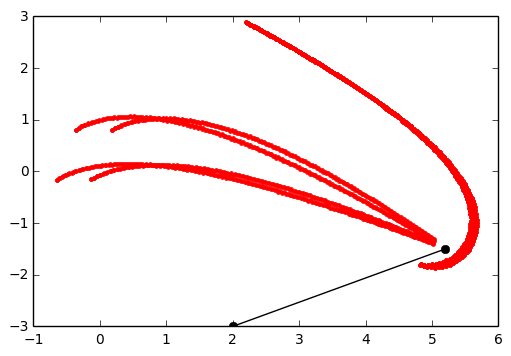

In [198]:
%matplotlib inline
colors = ['r','b','g']
for d in range(1): # drone_num
    color = colors[d]
    wp = np.array(waypointslists[d])
    plt.plot(wp[:,0],wp[:,1],'k'+'o')
    plt.plot(wp[:,0],wp[:,1],'k')
    for ci in range(len(traces[d])): # int()len(traces[d])
        #plt.plot(np.array(traces[d][ci][:])[:,3],np.array(traces[d][ci][:])[:,4],color)
        plt.plot(np.array(traces_orig[d][ci][:])[:,3],np.array(traces_orig[d][ci][:])[:,4],color + '.')
        #print np.array(traces_unified[d][ci][:])
        #for seg in range(len(traces_unified[d][ci])):
        #    plt.plot(np.array(traces_unified[d][ci][seg][:])[:,3],np.array(traces_unified[d][ci][seg][:])[:,4],color + '-')

In [45]:
print unsafesets

[[[11.9, 5.1], [12.9, 6.1]]]


u [[11.9, 5.1], [12.9, 6.1]]


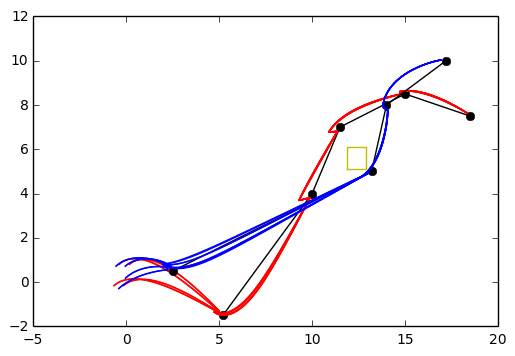

In [48]:
#%matplotlib inline
colors = ['r','b','g']

for d in range(2): # drone_num
    color = colors[d]
    
    wp = np.array(waypointslists[d])
    plt.plot(wp[:,0],wp[:,1],'k'+'o')
    plt.plot(wp[:,0],wp[:,1],'k')
    for ci in range(len(traces[d])):
        plt.plot(np.array(traces[d][ci][:])[:,3],np.array(traces[d][ci][:])[:,4], color)


# Create a Rectangle patch
for u in unsafesets:
    print "u",u
    u = np.array(u)
    rectpoints = [[u[0][0],u[0][1]],[u[1][0],u[0][1]],\
                  [u[1][0],u[0][1]],[u[1][0],u[1][1]],\
                  [u[0][0],u[1][1]],[u[0][0],u[0][1]]]
    rectpoints = np.array(rectpoints)
    plt.plot(rectpoints[:,0], rectpoints[:,1], 'y')
    
plt.show()

In [58]:
def mapUnsafeSets(unsafesets, sc, x_n, y_n):
    new_unsafesets = []
    for u in unsafesets:
        vertices = list(itertools.product(*u))
        new_vertices = []
        new_u = []
        for vertex in vertices:
            new_vertex = PositionPointCoordinateChange(sc, vertex[0], vertex[1], x_n, y_n)
            #print "new_vertex: ", new_vertex
            if len(new_u) == 0:
                new_u = [[new_vertex[0], new_vertex[1]], [new_vertex[0],new_vertex[1]]]
            else:
                new_u[0][0] = min(new_u[0][0], new_vertex[0])
                new_u[0][1] = min(new_u[0][1], new_vertex[1])
                new_u[1][0] = max(new_u[1][0], new_vertex[0])
                new_u[1][1] = max(new_u[1][1], new_vertex[1])
        new_unsafesets.append(new_u)
    return new_unsafesets
wp_o = [center[2],center[3]]
wp_n = [3.5,0.5]
sc = math.acos((wp_n[1] - wp_o[1]) / (math.sqrt((wp_n[0] - wp_o[0])*(wp_n[0] - wp_o[0]) + (wp_n[1] - wp_o[1])*(wp_n[1] - wp_o[1]))))
print "sc new: ", sc
if 0.5 > center[3]:
    sc = math.atan((3.5-(center[2]))/(0.5-(center[3])))
else:
    sc = (np.pi/2) + math.atan((center[3]-0.5)/(3.5-(center[2])))
center = [0.5, 0.9, -0.5, -0.5]
unsafesets = [[[11.9,5.1],[12.9,6.1]]]
mapUnsafeSets(unsafesets, sc, wp_n[0],wp_n[1])

sc new:  1.32581766367


[[[5.820855000871991, -6.790997501017324],
  [14.067066252107312, 1.4552137502179974]]]

In [59]:
def mapInitialSet(initialset, sc, x_n, y_n):
    new_initialset = []
    vertices = list(itertools.product(*initialset))
    new_vertices = []
    for vertex in vertices:
        new_vertex = PointCoordinateChange(sc, vertex, x_n, y_n)
        #print "new_vertex: ", new_vertex
        if len(new_initialset) == 0:
            new_initialset = [[new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]],\
                              [new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]]]
        else:
            new_initialset[0][0] = min(new_initialset[0][0], new_vertex[0])
            new_initialset[0][1] = min(new_initialset[0][1], new_vertex[1])
            new_initialset[0][2] = min(new_initialset[0][2], new_vertex[2])
            new_initialset[0][3] = min(new_initialset[0][3], new_vertex[3])
            new_initialset[1][0] = max(new_initialset[1][0], new_vertex[0])
            new_initialset[1][1] = max(new_initialset[1][1], new_vertex[1])
            new_initialset[1][2] = max(new_initialset[1][2], new_vertex[2])
            new_initialset[1][3] = max(new_initialset[1][3], new_vertex[3])
    return new_initialset
initset = [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]]
sc = 1.32581766367
wp_n = [3.5,0.5]
mapInitialSet(map(list, zip(*initset)), sc, wp_n[0], wp_n[1])

[[0.5, -0.42581766367000007, -0.9701425001376963, -4.123105625617661],
 [0.6, -0.41581766367000006, 0.2425356250425369, -2.9104275004374274]]

In [60]:
def getInitSetCenter(initialSet):
    center = len(initialSet[0][:])
    for i in range(len(center)):
        center[i] = (initialSet[0][i] + initialSet[1])/2
    return center

In [61]:
def isInSet(pointt, sett):
    assert len(pointt) == len(sett[0][:])
    for i in range(len(pointt)):
        if pointt[i] > sett[1][i] or pointt[i] < sett[0][i]:
            return False 
    return True

In [62]:
def doRectsInter(rect1, rect2):
    for i in len(rect1[0][:]):
        if rect1[0][i] > rect2[1][i] or rect1[1][i] < rect2[0][i]:
            return False
    return True

In [63]:
def doRectContains(rect1, rect2):
    for i in len(rect1[0][:]):
        if rect1[0][i] < rect2[0][i] or rect1[1][i] > rect2[1][i]:
            return False
    return True

In [64]:
def getSetIntIndex(sol, sett):
    for i in len(sol):
        if isInSet(sol[i], sett):
            return i
    return -1

In [ ]:
def computeTube(k, gamma, initset, goalset, unsafesets, dimensions, time_step, time_bound):
    queue = deque([initset])
    red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
    t = time_List(time_step, time_bound)
    safe = True
    while len(queue) > 0:
        cur_initset = initqueue.popleft()
        cur_center = getInitSetCenter([cur_initset.lowerBound, cur_initset.upperBound])
        sol = odeint(standardized_position,cur_center,t,args=red_args, hmax = time_step)
        for unsafeset in unsafesets:
            interIndex = getSetIntIndex(sol, unsafeset)
            if interIndex == -1:
                safe = False
                return UNSAFE, sol, []
        interIndex = getSetIntIndex(sol, goalset)
        if interIndex == -1:
            initqueue.append(cur_initset)
            time_bound = 1.5 * time_bound
            t = time_List(time_step, time_bound)
            continue
        trace = []
        for i in range(len(sol)):
            s = sol[i]
            if len(trace) > 0 and i==0: # skip the first state since it already appeared as the last one in the previous part of the trace
                continue
            tmp = []
            tmp.append(t[i])
            tmp.append(float(sol[i,0]))
            tmp.append(float(sol[i,1]))
            tmp.append(float(sol[i,2]))
            tmp.append(float(sol[i,3]))
            trace.append(tmp)
        
        tube = bloatToTube(k, gamma, cur_initset, trace, len(initset[0][:]))
        
        
        
        
        
    

In [ ]:
with open("traces.csv","w") as f:
        wr = csv.writer(f)
        for d in range(drone_num):
            wr.write("")
            for i in range(len(traces[d])):
                wr.writerows(traces[d][i])
                wr.write('\n')

In [50]:
a = []
len(a)

0